# **BN5211 Medical Robotic Intelligence Project 1**

In this project, you will embark on a deep learning journey of Medical Robotics by completing the following tasks:

*   Task 1. Building Neural Network for surgical instrument classification (40%)
*   Task 2. Surgical Action recognition (25%)
*   Task 3. Contrastive learning - Momentum Contrast for Unsupervised Visual Representation Learning (35%)


**Before doing the project, please read the instructions carefully (failure to do so will be penalized):**

### Submission (upload to Canvas), you need to submit two files:

1. Completed **`.ipynb`** (all cells executed; outputs saved).
2. One merged PDF — combine the following into a single PDF:
- Notebook PDF — export of your .ipynb (Colab: File → Print → Save as PDF).
- Analysis Report — written answers for Q1.1.2, Q1.4, Q2.4, Q3.5 (Word/LaTeX/Markdown → export to PDF).



### General Instructions
1. Implement your code within "TODO" and "END OF YOUR CODE"; **do NOT** modify code outside the answer area.
2. Keep code clean, readable (add meaningful comments if needed), and runnable.
3. Ensure important outputs via `print` are visible in the notebook/PDF; this is the basis for marking.
4. Write answers in the given markdown cells; keep them clear and concise.
5. Submit to **Assignments → Project 1** on Canvas **before 6 October 2025, 10:00 (SGT)**.
6. This is an individual project. You may discuss technical issues, but **DO NOT** share solutions. Any plagiarism → immediate zero and report to the University.
7. Questions? Contact **TA Mr. Liu, Haofeng (haofeng.liu@u.nus.edu)** or **Asst Prof. Jin, Yueming (imvr.course@gmail.com)**.
8. Late policy (strict): 0–1h 90%; 1–12h 80%; 12–24h 60%; 24–48h 40%; 48–72h 20%; >72h 0.
9. Colab resource limits: plan your runs; free GPU time ~3–12h/day.
10. Be mindful of overfitting/underfitting and mitigate appropriately.


## Preparation

### Loading packages

Please install the packages listed below if you haven't done so.

It's recommended to use the default setting in colab.

In [5]:
! pip install torchsummary


In [2]:
import torch
import os
from torchsummary import summary

print('torch version: ', torch.__version__)

torch version:  2.8.0+cu126


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Mounting google drive

Please mount your google drive for the following dataset reading. (Upload the data to your google drive)

In [22]:
from google.colab import drive
drive.mount('/content/drive')
drive_root = '/content/drive/MyDrive/NUS/BN5211'
# drive_root = '../'  # For local usage

# Set the data root
dataset_root = os.path.join(drive_root, 'Dataset')
weights_root = os.path.join(drive_root, 'weights')
full_dataset_dir = os.path.join(drive_root, 'dataset-full')  # For task 3

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Successful mount will make the drive folder visible on the left. Please arrange the provided dataset and pretrained weights following the marked red boxes. Note that '/drive/MyDrive/' denotes the root of your Google Drive, so you just need to create a folder 'BN5211' in your Google Drive and arrange the files in the folder.

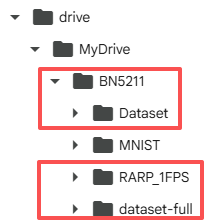

### Importing libraries

Please import the basic libraries and set the running device.

In [23]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torch.utils.data.dataset as Dataset
import torch.nn as nn

from PIL import Image
from torchvision import models

In [24]:
if torch.cuda.is_available():
  device = 'cuda:0'  # choose your device here
else:
  device = 'cpu'
print('Using device:', device)

Using device: cuda:0


### Prepare dataset

The surgical instrument dataset is now available! The data reading follows the codes:

In [25]:
path_train = os.path.join(dataset_root, 'train')
path_val = os.path.join(dataset_root, 'val')
path_test = os.path.join(dataset_root, 'test')

img_list_train = []
img_list_val = []
img_list_test = []

size_train = 0
size_val = 0
size_test = 0

# read all images' path
for root,dirs,files in os.walk(path_train):
  for file in files:
    img_list_train.append(os.path.join(root, file))
size_train = len(img_list_train)

for root,dirs,files in os.walk(path_val):
  for file in files:
    img_list_val.append(os.path.join(root, file))
size_val = len(img_list_val)

for root,dirs,files in os.walk(path_test):
  for file in files:
    img_list_test.append(os.path.join(root, file))
size_test = len(img_list_test)

In [26]:
# define the data class
class ImageDataset(Dataset.Dataset):
  def __init__(self, img_list, is_train=True):
    self.img_list = img_list
    self.is_train = is_train
    self.augmentation_transforms = torchvision.transforms.Compose([
      torchvision.transforms.RandomHorizontalFlip(),
      torchvision.transforms.RandomVerticalFlip(),
      torchvision.transforms.RandomRotation(90)
    ])
    self.resize = torchvision.transforms.Resize((175, 300))
    self.image_transforms = torchvision.transforms.Compose([
      torchvision.transforms.ToTensor(),
      torchvision.transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    self.label_dict = {
      'Bi': 0,
      'Cl': 1,
      'Gr': 2,
      'Ho': 3,
      'Ir': 4,
      'Sc': 5,
      'Sp': 6
    }

  def __len__(self):
    return len(self.img_list)

  def __getitem__(self, index):
    # image name looks like 'v01_007125_Gr.jpg'
    lab_value = self.img_list[index].split('_')[-1].split('.')[0]
    label = self.label_dict[lab_value]
    img_path = self.img_list[index]
    image = Image.open(img_path)
    image = self.resize(image)

    # data augmentation for training
    if self.is_train:
      image = self.augmentation_transforms(image)

    image_tensor = self.image_transforms(image)
    image = np.array(image)
    label = torch.tensor(label, dtype=torch.long)

    return image, image_tensor, label


In [27]:
# build dataset
dataset_train = ImageDataset(img_list_train, True)
dataset_val = ImageDataset(img_list_val, False)
dataset_test = ImageDataset(img_list_test, False)

To test and visualize the dataset loading.

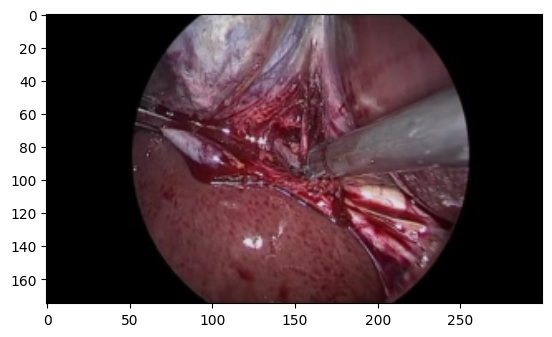

In [28]:
# The visual result can be changed by changing the value of __getitem__(1)
image1, image_norm1, label1 = dataset_test.__getitem__(1)  # due to different random seed, the result may vary
plt.imshow(image1, interpolation='bilinear')
plt.show()

## Task 1: Building Neural Network for surgical instrument classification [40%]

In this task, you are expected to build a convolutional neural network (CNN) to classify the surgical instrument from different surgical images and explore different strategies that further strengthen its performance.

### **[10%] Q1.1**: Design your first Model

A convolutional neural network (CNN) is the most famous and widely applied in different computer version (CV) tasks, including classification, segmentation, and regression. A basic CNN consists of the following layers (the introduction of layers can be found from Lec1_supp_Introduction-of-python&pytorch):


*   **Convolutional layer:** It conducts convolutional operations on the image to generate feature maps.
*   **Linear layer:** It applies a linear transformation to the incoming data: y=xA+b. x is the input, y is the output, b is the bias.
*   **Pooling layer:** It is an operation to extract important information and reduce the spatial size of feature maps, which can remove unimportant information and reduce computing overhead.
*   **ReLU layer:** It is the motivation function. There are lots of motivation functions in deep learning.
*   **Batch Normalization:** It is the normalization operation.

If you are not familiar with CNN, more details can be found from [the blog](https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53).

**[7%] Q1.1.1:**  Define your first CNN and explain the design.

Please follow the TODOs provides below. (Refer to [torch.nn](https://pytorch.org/docs/stable/nn.html) for detailed instructions of building basic blocks with PyTorch.)

In [33]:
class ConvNet(torch.nn.Module):
  def __init__(self):
    super(ConvNet, self).__init__()
    ##############################################################################
    # TODO: Implement a CNN model.
    # Requirements:
    # - Use convolution, batch normalization, activation (ReLU), pooling,
    #   fully connected layers, and at least one regularization method (e.g., Dropout).
    # - Input:  Tensor of shape (B, 3, H, W), with H ≥ 64 and W ≥ 64
    # - Output: Class logits of shape (B, 7)
    # - The network should be shape-agnostic (do not hard-code H or W).
    ##############################################################################
    # Block 1:         3 x 175 x 300 --> 32 x 87 x 150
    self.block1 = torch.nn.Sequential(
            torch.nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )

    # Block 2:         32 x 87 x 150 --> 64 x 43 x 75
    self.block2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )

    # Block 3:         64 x 43 x 75 --> 128 x 21 x 37
    self.block3 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )

    # Block 4:          128 x 21 x 37 --> 256 x 10 x 18
    self.block4 = torch.nn.Sequential(
            torch.nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(256),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )

    # Block 5:          256 x 10 x 18 -> 256 x 5 x 9
    self.block5 = torch.nn.Sequential(
            torch.nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(256),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )

    # Linear layers:   256 x 5 x 9 --> 2048 --> 1024 --> 7
    self.fc1 = torch.nn.Linear(256 * 5 * 9, 2048)
    self.fc2 = torch.nn.Linear(2048, 1024)
    self.fc3 = torch.nn.Linear(1024, 7)

    # self.fc1 = nn.Linear(256 * 5 * 9, 512)  # Instead of 2048
    # self.fc2 = nn.Linear(512, 128)          # Instead of 1024
    # self.fc3 = nn.Linear(128, 7)

    # Dropout layers
    self.dropout1 = torch.nn.Dropout(0.6)
    self.dropout2 = torch.nn.Dropout(0.3)


    ##############################################################################
    #             END OF YOUR CODE
    ##############################################################################

  def forward(self, x):
    ##############################################################################
    # TODO: Implement the forward pass.
    # - Pass the input through the convolutional blocks.
    # - Flatten the feature map.
    # - Apply fully connected layers with dropout.
    # - Return class logits.
    ##############################################################################



    # Block 1:         3 x 175 x 300 --> 32 x 87 x 150
    x = self.block1(x)

    # Block 2:         32 x 87 x 150 --> 64 x 43 x 75
    x = self.block2(x)

    # Block 3:         64 x 43 x 75 --> 128 x 21 x 37
    x = self.block3(x)

    # Block 4:          128 x 21 x 37 --> 256 x 10 x 18
    x = self.block4(x)

    # Block 5:          256 x 10 x 18 -> 256 x 5 x 9
    x = self.block5(x)

    # Flatten the feature map
    x = x.view(x.size(0), -1)


    # Linear layers:   256 x 5 x 9 --> 11520 --> 2048 --> 1024 --> 7
    x = torch.flatten(x, 1)
    x = self.dropout1(torch.relu(self.fc1(x)))
    x = self.dropout2(torch.relu(self.fc2(x)))
    logits = self.fc3(x)

    # Apply fc layers with dropout
    return logits




    ##############################################################################
    #              END OF YOUR CODE
    ##############################################################################
    return x

model = ConvNet()
model.to(device)
summary(model, (3, 175, 300))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 175, 300]             896
       BatchNorm2d-2         [-1, 32, 175, 300]              64
              ReLU-3         [-1, 32, 175, 300]               0
         MaxPool2d-4          [-1, 32, 87, 150]               0
            Conv2d-5          [-1, 64, 87, 150]          18,496
       BatchNorm2d-6          [-1, 64, 87, 150]             128
              ReLU-7          [-1, 64, 87, 150]               0
         MaxPool2d-8           [-1, 64, 43, 75]               0
            Conv2d-9          [-1, 128, 43, 75]          73,856
      BatchNorm2d-10          [-1, 128, 43, 75]             256
             ReLU-11          [-1, 128, 43, 75]               0
        MaxPool2d-12          [-1, 128, 21, 37]               0
           Conv2d-13          [-1, 256, 21, 37]         295,168
      BatchNorm2d-14          [-1, 256,

---

**[3%] Q1.1.2:**: Provide a brief explanation of your design choices in the pdf file.

---


### **[5%] Q1.2** Train and evaluate your model

Some default settings for training.

In [25]:
# Hyperparameters
batch_size = 60

# Define loss function
criterion = torch.nn.CrossEntropyLoss()

dataloader_train = torch.utils.data.DataLoader(dataset=dataset_train,batch_size=batch_size,shuffle=True)
dataloader_test = torch.utils.data.DataLoader(dataset=dataset_test,batch_size=batch_size,shuffle=False)
dataloader_val = torch.utils.data.DataLoader(dataset=dataset_val,batch_size=batch_size,shuffle=False)

In [13]:
import matplotlib.pyplot as plt

def plot_loss(epoch_losses):
  # Plot training loss curves to monitor model performance during training.

  # Average loss per epoch (smoother, easier to see long-term convergence)
  plt.figure(figsize=(6,4))
  plt.plot(range(1, len(epoch_losses) + 1), epoch_losses)
  plt.xlabel('Epoch')
  plt.ylabel('Average Loss')
  plt.title('Training Loss (per epoch)')
  plt.grid(True)
  plt.show()


Define the training function and testing function

In [14]:
def train_net(model, dataloader_train, dataloader_val, optimizer, save_path, total_epochs=200):
  start=time.time()
  model.train()
  best_val_accuracy = 0
  train_losses_iter = []   # loss per mini-batch
  epoch_losses = []        # loss per epoch
  for epoch in range(total_epochs):
    # Set the running quantities to zero at the beginning of the epoch
    running_loss = 0
    running_correct = 0
    for step, (image, image_tensor, label) in enumerate(dataloader_train):
      ##############################################################################
      # TODO: Implement the training process.
      # Requirements:
      # - Load inputs and labels to device
      # - Zero gradients
      # - Forward pass through the model
      # - Compute loss
      # - Backward pass and update parameters
      ##############################################################################
      # Load inputs and labels to device
      image_tensor = image_tensor.to(device)
      label = label.to(device)

      # Set the gradients to zeros
      optimizer.zero_grad()

      # Forward the batch data through the net
      pred = model(image_tensor)

      # Compute the average of the losses of the data points in the minibatch
      loss = criterion(pred, label)

      # Backward pass to compute gradients
      loss.backward()

      # Do one step of stochastic gradient descent
      optimizer.step()


      ##############################################################################
      #                 END OF YOUR CODE
      ##############################################################################
      # Add the loss of this batch to the running loss
      running_loss += loss * len(image_tensor)
      train_losses_iter.append(running_loss.item())
      # Count correct predictions
      running_correct += (pred.argmax(1) == label).type(torch.float).sum().item()

    # Compute stats for the full training set
    avg_loss = running_loss / len(dataloader_train.dataset)
    total_correct = running_correct / len(dataloader_train.dataset)
    epoch_losses.append(avg_loss.item())
    elapsed = (time.time() - start) / 60

    print('epoch= {} \t time= {:.2f} min \t loss= {:.3f} \t accuracy= {:.2f}%'.format(epoch, elapsed, avg_loss, total_correct * 100))
    # Start validation
    if epoch % 5==0:
      this_val_correct = eval_on_dataset(model, dataloader_val)
      model.train()
      if this_val_correct > best_val_accuracy:
        best_val_accuracy = this_val_correct
        torch.save(model.state_dict(), save_path)
        print('Model saved at epoch', epoch)
  plot_loss(epoch_losses)
  return epoch_losses

In [15]:
@torch.inference_mode()
def eval_on_dataset(model, dataloader_test):
  model.eval()
  running_correct = 0
  running_loss = 0
  for step, (image, image_tensor, label) in enumerate(dataloader_test):
    ##############################################################################
    # TODO: Implement the evaluation step for each batch.
    # - Move inputs and labels to the device
    # - Perform a forward pass through the model
    # - Compute the loss
    # - Obtain predictions for accuracy calculation
    ##############################################################################
    # Move inputs and labels to the device
    image_tensor = image_tensor.to(device)
    label = label.to(device)

    # Perform a forward pass through the model
    pred = model(image_tensor)

    # Compute the loss
    loss = criterion(pred, label)

    # Obtain predictions for accuracy calculation
    predictions = pred.argmax(1)

    ##############################################################################
    #               END OF YOUR CODE
    ##############################################################################
    # Add the loss of this batch to the running loss
    running_loss += loss * len(image_tensor)
    # Compute the error made on this batch and add it to the running error
    running_correct += (pred.argmax(1) == label).type(torch.float).sum().item()

  total_correct = running_correct / len(dataloader_test.dataset)
  print('Accuracy on the evaluation dataset = {:.2f}%, loss = {:.2f}'.format(total_correct * 100, running_loss / len(dataloader_test.dataset)))
  return total_correct

Run `train_net` and start training. After training, your error on the testing set should be under 45% (if not, please look back and check your codes, there might be something wrong with the network architecture or training process). Once the training phrase is completed, save the trained model on your device so it can be directly loaded in the following tasks.

epoch= 0 	 time= 0.03 min 	 loss= 1.977 	 accuracy= 15.17%
Accuracy on the evaluation dataset = 15.15%, loss = 1.95
Model saved at epoch 0
epoch= 1 	 time= 0.07 min 	 loss= 1.926 	 accuracy= 19.10%
epoch= 2 	 time= 0.10 min 	 loss= 1.930 	 accuracy= 21.91%
epoch= 3 	 time= 0.13 min 	 loss= 1.891 	 accuracy= 19.10%
epoch= 4 	 time= 0.16 min 	 loss= 1.916 	 accuracy= 22.47%
epoch= 5 	 time= 0.19 min 	 loss= 1.917 	 accuracy= 17.42%
Accuracy on the evaluation dataset = 15.15%, loss = 1.94
epoch= 6 	 time= 0.25 min 	 loss= 1.886 	 accuracy= 20.79%
epoch= 7 	 time= 0.28 min 	 loss= 1.870 	 accuracy= 22.47%
epoch= 8 	 time= 0.31 min 	 loss= 1.839 	 accuracy= 22.47%
epoch= 9 	 time= 0.34 min 	 loss= 1.819 	 accuracy= 22.47%
epoch= 10 	 time= 0.37 min 	 loss= 1.788 	 accuracy= 31.46%
Accuracy on the evaluation dataset = 15.15%, loss = 1.93
epoch= 11 	 time= 0.40 min 	 loss= 1.771 	 accuracy= 30.90%
epoch= 12 	 time= 0.43 min 	 loss= 1.756 	 accuracy= 33.15%
epoch= 13 	 time= 0.46 min 	 loss= 1

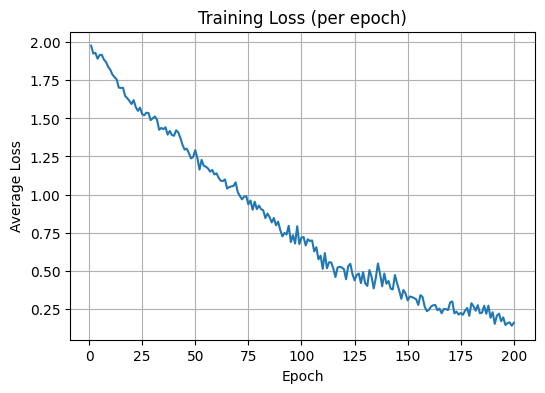

In [34]:
# Hyperparameters
epochs = 200
learning_rate = 0.001

model = ConvNet()
model.to(device)
# Set up optimizer
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
# Save the trained model
os.makedirs(weights_root, exist_ok=True)
save_path = os.path.join(weights_root, 'model_cnn_task1_1_new_.pkl')
# Start training
epoch_losses = train_net(model, dataloader_train, dataloader_val, optimizer, save_path, epochs)

In [36]:
##############################################################################
# TODO: Test the trained model on the test dataset.
# - Load the saved model weights from file
# - Call the evaluation function on the test dataloader
##############################################################################
# Start testing
model_path = os.path.join(weights_root, 'model_cnn_task1_1_new_.pkl')
if os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path, map_location=device))
    print(f"Model loaded successfully from {model_path}")
else:
    print(f"Model file {model_path} not found. Please check the path.")

# Set model to evaluation mode
model.eval()

# Call the evaluation function on the test dataloader
print("Evaluating model on test dataset...")
test_accuracy = eval_on_dataset(model, dataloader_test)  # Removed the third argument (criterion)

print(f"Final Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

##############################################################################
#               END OF YOUR CODE
##############################################################################

Model loaded successfully from /content/drive/MyDrive/NUS/BN5211/weights/model_cnn_task1_1_new_.pkl
Evaluating model on test dataset...
Accuracy on the evaluation dataset = 63.33%, loss = 1.15
Final Test Accuracy: 0.6333 (63.33%)


### Ploting the Results

Now the model has been trained, the visual results can be ploted. (There is nothing to implement in this section.)

In [37]:
assert os.path.exists(save_path), 'train the model first'
# Load the trained model
model.load_state_dict(torch.load(save_path, map_location=torch.device('cpu')))
print('Model loaded from', save_path)
model.to(device)
model.eval()

Model loaded from /content/drive/MyDrive/NUS/BN5211/weights/model_cnn_task1_1_new_.pkl


ConvNet(
  (block1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(

Label:3.00
Pred:3.00 and prob:0.98


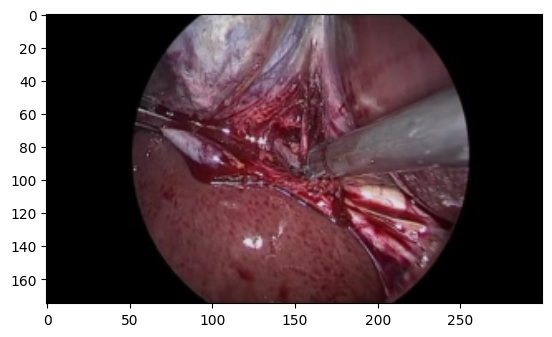

In [38]:
# Choose a picture at random
image_test, image_tensor_test, label_test = dataset_test.__getitem__(2)

image_test = torch.tensor(image_test, dtype=torch.int)
image_test = np.transpose(image_test, [1, 2, 0])

image_tensor_test = image_tensor_test.to(device)
image_tensor_test = torch.unsqueeze(image_tensor_test, dim=0)
scores = model(image_tensor_test)
probs = F.softmax(scores, dim=1)
print('Label:{:.2f}'.format(label_test.data.cpu().numpy()))
print('Pred:{:.2f} and prob:{:.2f}'.format(probs.argmax().data.cpu().numpy(),probs.max().data.cpu().numpy()))

plt.imshow(image1, interpolation='bilinear')
plt.show()

### **[20%] Q1.3** Refining the Model

Although the Vallina model has achieved fair classification results, the test error is still high, leaving huge room for further improvement. There are lots of methods to refine your model, such as **modifying the network architecture** (e.g., building up a new backbone with one Resnet block), **optimizing the learning strategy** (e.g., changing the SGD optimizer to Adam), **tuning the hyperparameters** (e.g., increasing the batch size to 16), and **fine-tuning with a pretrained model** (e.g., use the pretrained weights trained on ImageNet), etc.

Please try these three different methods to improve your model's performance, and discuss why these changes can work. Design and conduct your own experiments using the coding cell below, and present your experimental results and analysis in a decent way (e.g., drawing some neat figures/tables can help to convey your thoughts effectively).


In [16]:
# 1. Build up a ResNet18 without using torchvision.models

class ResNet18Custom(torch.nn.Module):
##############################################################################
# TODO: Implement a ResNet-18 from scratch (without torchvision.models).
# - Refer to He et al., CVPR 2016 (arXiv:1512.03385).
# - You may consult the official PyTorch implementation:
#   https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py
# - Do not copy-paste; instead, understand the architecture and write
#   your own implementation.
##############################################################################
    def __init__(self, num_classes=7):
        super(ResNet18Custom, self).__init__()

        # Initial conv + pool
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Keep track of channels
        self.in_channels = 64

        # ResNet-18 layers: [2,2,2,2] blocks
        self.layer1 = self._make_layer(64, blocks=2, stride=1)
        self.layer2 = self._make_layer(128, blocks=2, stride=2)
        self.layer3 = self._make_layer(256, blocks=2, stride=2)
        self.layer4 = self._make_layer(512, blocks=2, stride=2)

        # Global pooling + FC
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

        self._initialize_weights()

    def _make_layer(self, out_channels, blocks, stride=1):
        """Make one stage with given #blocks."""
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1,
                          stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

        layers = []
        # First block (may need downsampling)
        layers.append(ResidualBlock(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels

        # Remaining blocks (no downsample, same shape)
        for _ in range(1, blocks):
            layers.append(ResidualBlock(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x


class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out



##############################################################################
#                 END OF YOUR CODE
##############################################################################

Training ResNet18 with Adam optim
epoch= 0 	 time= 0.02 min 	 loss= 1.957 	 accuracy= 14.61%
Accuracy on the evaluation dataset = 12.12%, loss = 1.95
Model saved at epoch 0
epoch= 1 	 time= 0.05 min 	 loss= 1.865 	 accuracy= 27.53%
epoch= 2 	 time= 0.07 min 	 loss= 1.796 	 accuracy= 34.27%
epoch= 3 	 time= 0.10 min 	 loss= 1.752 	 accuracy= 34.83%
epoch= 4 	 time= 0.12 min 	 loss= 1.691 	 accuracy= 39.33%
epoch= 5 	 time= 0.14 min 	 loss= 1.639 	 accuracy= 35.96%
Accuracy on the evaluation dataset = 12.12%, loss = 3.89
epoch= 6 	 time= 0.17 min 	 loss= 1.639 	 accuracy= 34.83%
epoch= 7 	 time= 0.19 min 	 loss= 1.593 	 accuracy= 42.13%
epoch= 8 	 time= 0.24 min 	 loss= 1.560 	 accuracy= 46.07%
epoch= 9 	 time= 0.26 min 	 loss= 1.533 	 accuracy= 44.94%
epoch= 10 	 time= 0.28 min 	 loss= 1.503 	 accuracy= 47.75%
Accuracy on the evaluation dataset = 21.21%, loss = 2.79
Model saved at epoch 10
epoch= 11 	 time= 0.31 min 	 loss= 1.436 	 accuracy= 53.37%
epoch= 12 	 time= 0.34 min 	 loss= 1.3

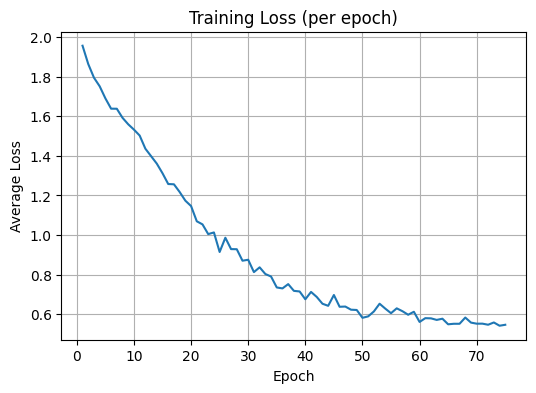

Loading best model and evaluating on test dataset...
Accuracy on the evaluation dataset = 73.33%, loss = 1.16
ResNet18 with Adam - Final Test Accuracy: 0.7333 (73.33%)


In [66]:
# 2. Change SGD optimizer to Adam.
model = ResNet18Custom()
model.to(device)
save_path = os.path.join(weights_root, 'model_cnn_task1_2.pkl')

##############################################################################
# TODO: Modify the training setup using Adam optimizer.
# - Replace SGD with Adam optimizer
# - Set appropriate learning rate and number of epochs
# - Train the model and save the best checkpoint
# - Reload the saved model and run evaluation on the test dataset
##############################################################################

# learning_rate = 0.001  # Adjust to avoid underfitting
epochs = 75  # Adjust to avoid underfitting

# Set up Adam optimizer with appropriate learning rate
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=1e-4,
    weight_decay=5e-4
)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
# Train the model with Adam optimizer
print("Training ResNet18 with Adam optim")
epoch_losses = train_net(model, dataloader_train, dataloader_val, optimizer, save_path, epochs)

# Reload the saved model and evaluate on test dataset
print("Loading best model and evaluating on test dataset...")
model.load_state_dict(torch.load(save_path, map_location=device))
model.eval()

# Run evaluation on test dataset
test_accuracy = eval_on_dataset(model, dataloader_test)
print(f"ResNet18 with Adam - Final Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")


##############################################################################
#            END OF YOUR CODE
##############################################################################


Training ResNet18 with batch size 16...
epoch= 0 	 time= 0.02 min 	 loss= 1.953 	 accuracy= 16.29%
Accuracy on the evaluation dataset = 15.15%, loss = 1.94
Model saved at epoch 0
epoch= 1 	 time= 0.05 min 	 loss= 1.904 	 accuracy= 22.47%
epoch= 2 	 time= 0.08 min 	 loss= 1.856 	 accuracy= 23.03%
epoch= 3 	 time= 0.10 min 	 loss= 1.769 	 accuracy= 37.64%
epoch= 4 	 time= 0.12 min 	 loss= 1.755 	 accuracy= 29.78%
epoch= 5 	 time= 0.15 min 	 loss= 1.730 	 accuracy= 33.15%
Accuracy on the evaluation dataset = 30.30%, loss = 1.78
Model saved at epoch 5
epoch= 6 	 time= 0.18 min 	 loss= 1.661 	 accuracy= 36.52%
epoch= 7 	 time= 0.20 min 	 loss= 1.661 	 accuracy= 36.52%
epoch= 8 	 time= 0.23 min 	 loss= 1.615 	 accuracy= 41.57%
epoch= 9 	 time= 0.25 min 	 loss= 1.583 	 accuracy= 42.70%
epoch= 10 	 time= 0.27 min 	 loss= 1.563 	 accuracy= 46.07%
Accuracy on the evaluation dataset = 45.45%, loss = 1.65
Model saved at epoch 10
epoch= 11 	 time= 0.31 min 	 loss= 1.488 	 accuracy= 50.56%
epoch= 12

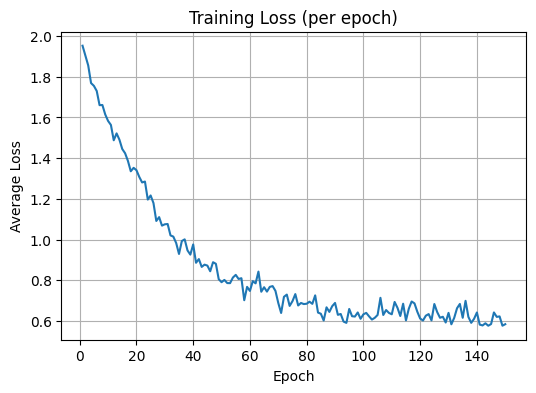

Loading best model and evaluating on test dataset...
Accuracy on the evaluation dataset = 72.22%, loss = 1.08
ResNet18 with batch size 16 - Final Test Accuracy: 0.7222 (72.22%)


In [30]:
# 3. Increase batch size to 16.
model = ResNet18Custom()
model.to(device)
save_path = os.path.join(weights_root, 'model_cnn_task1_3.pkl')

##############################################################################
# TODO: Train the model with a larger batch size.
# - Set the training batch size to 16
# - Train the model and save the best checkpoint
# - Reload the saved model and evaluate on the test dataset
##############################################################################

# Set batch size to 16
batch_size = 16

# Create new dataloaders with batch size 16 (num_workers=0 to avoid multiprocessing issues)
dataloader_train_bs16 = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=0)
dataloader_val_bs16 = torch.utils.data.DataLoader(dataset_val, batch_size=batch_size, shuffle=False, num_workers=0)
dataloader_test_bs16 = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=False, num_workers=0)

learning_rate = 1e-3 # Adjust to avoid underfitting
epochs = 150 # Adjust to avoid underfitting

# Set up optimizer with larger batch size
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=5e-4)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=1e-3,
    steps_per_epoch=len(dataloader_train_bs16),
    epochs=epochs
)


# Train the model with batch size 16
print("Training ResNet18 with batch size 16...")
epoch_losses = train_net(model, dataloader_train_bs16, dataloader_val_bs16, optimizer, save_path, epochs)

# Reload the saved model and evaluate on test dataset
print("Loading best model and evaluating on test dataset...")
model.load_state_dict(torch.load(save_path, map_location=device))
model.eval()

# Run evaluation on test dataset
test_accuracy = eval_on_dataset(model, dataloader_test_bs16)
print(f"ResNet18 with batch size 16 - Final Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")


##############################################################################
#               END OF YOUR CODE
##############################################################################

Transfer learning is a technique that allows you to use a pre-trained model on a new dataset. In this task, you are expected to use the pre-trained ResNet18 model to classify the surgical instrument. The pre-trained model can be obtained from the PyTorch library.
Furthermore, this technique can also help you adapt the newest-trend foundation into downstream tasks, which can save you a lot of time and computational resources.
Please write down your code in the following cell to conduct the transfer learning task.

Training PyTorch ResNet18 without pretrained weights...
epoch= 0 	 time= 0.03 min 	 loss= 2.160 	 accuracy= 17.98%
Accuracy on the evaluation dataset = 3.03%, loss = 2.13
Model saved at epoch 0
epoch= 1 	 time= 0.07 min 	 loss= 1.771 	 accuracy= 31.46%
epoch= 2 	 time= 0.09 min 	 loss= 1.698 	 accuracy= 32.58%
epoch= 3 	 time= 0.12 min 	 loss= 1.475 	 accuracy= 43.26%
epoch= 4 	 time= 0.16 min 	 loss= 1.340 	 accuracy= 48.31%
epoch= 5 	 time= 0.18 min 	 loss= 1.157 	 accuracy= 59.55%
Accuracy on the evaluation dataset = 24.24%, loss = 10.18
Model saved at epoch 5
epoch= 6 	 time= 0.22 min 	 loss= 1.128 	 accuracy= 55.62%
epoch= 7 	 time= 0.25 min 	 loss= 1.089 	 accuracy= 54.49%
epoch= 8 	 time= 0.28 min 	 loss= 0.885 	 accuracy= 70.79%
epoch= 9 	 time= 0.31 min 	 loss= 0.892 	 accuracy= 66.29%
epoch= 10 	 time= 0.34 min 	 loss= 0.892 	 accuracy= 66.29%
Accuracy on the evaluation dataset = 30.30%, loss = 3.91
Model saved at epoch 10
epoch= 11 	 time= 0.38 min 	 loss= 0.693 	 accuracy= 

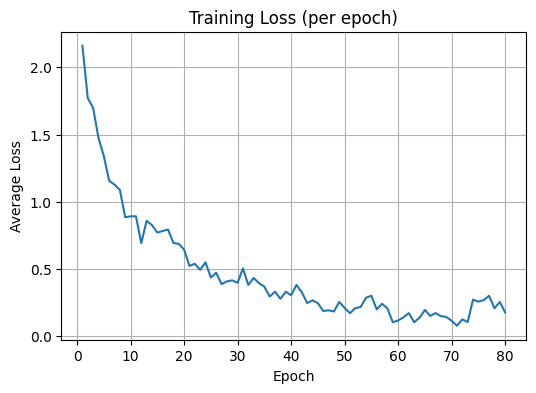

Loading best model and evaluating on test dataset...
Accuracy on the evaluation dataset = 61.11%, loss = 1.50
PyTorch ResNet18 (no pretrained) - Final Test Accuracy: 0.6111 (61.11%)


In [20]:
# 4.1 Use the pytorch resnet18 with pretrained weights trained on ImageNet.
from torchvision.models import resnet18 as pytorch_resnet18
# For comparison, we firstly train the resnet18 without pretrained weights
model = pytorch_resnet18(pretrained=False)
save_path = os.path.join(weights_root, 'model_cnn_task1_4_1.pkl')

# The forward function of resnet18 is:
# def forward(self, x: Tensor) -> Tensor:
#     x = self.conv1(x)
#     x = self.bn1(x)
#     x = self.relu(x)
#     x = self.maxpool(x)
#
#     x = self.layer1(x)
#     x = self.layer2(x)
#     x = self.layer3(x)
#     x = self.layer4(x)
#
#     x = self.avgpool(x)
#     x = torch.flatten(x, 1)
#     x = self.fc(x)
#     return x

##############################################################################
# TODO: Train a ResNet18 from torchvision without pretrained weights.
# - Initialize torchvision ResNet18 with random weights (pretrained=False)
# - Replace the final fully connected layer with output size 7
# - Use Adam optimizer with suitable learning rate and number of epochs
# - Train the model, save the best checkpoint, then reload and evaluate on test set
##############################################################################
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 7)

learning_rate = 0.001  # Adjust to avoid underfitting
epochs = 80  # Adjust to avoid underfitting

model.to(device)

# Set up optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


# scheduler = torch.optim.lr_scheduler.OneCycleLR(
#     optimizer, max_lr=1e-3,
#     steps_per_epoch=len(dataloader_train_bs16),
#     epochs=epochs
# )
# Train the model
print("Training PyTorch ResNet18 without pretrained weights...")
epoch_losses = train_net(model, dataloader_train, dataloader_val, optimizer, save_path, epochs)

# Reload the saved model and evaluate on test dataset
print("Loading best model and evaluating on test dataset...")
model.load_state_dict(torch.load(save_path, map_location=device))
model.eval()

# Run evaluation on test dataset
test_accuracy = eval_on_dataset(model, dataloader_test)
print(f"PyTorch ResNet18 (no pretrained) - Final Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

##############################################################################
#               END OF YOUR CODE
##############################################################################

Training PyTorch ResNet18 with pretrained weights (transfer learning)...
epoch= 0 	 time= 0.03 min 	 loss= 1.935 	 accuracy= 18.54%
Accuracy on the evaluation dataset = 33.33%, loss = 1.80
Model saved at epoch 0
epoch= 1 	 time= 0.07 min 	 loss= 1.603 	 accuracy= 47.75%
epoch= 2 	 time= 0.10 min 	 loss= 1.284 	 accuracy= 72.47%
epoch= 3 	 time= 0.13 min 	 loss= 1.063 	 accuracy= 75.28%
epoch= 4 	 time= 0.16 min 	 loss= 0.878 	 accuracy= 79.78%
epoch= 5 	 time= 0.19 min 	 loss= 0.724 	 accuracy= 84.27%
Accuracy on the evaluation dataset = 72.73%, loss = 0.89
Model saved at epoch 5
epoch= 6 	 time= 0.22 min 	 loss= 0.609 	 accuracy= 87.64%
epoch= 7 	 time= 0.26 min 	 loss= 0.470 	 accuracy= 89.89%
epoch= 8 	 time= 0.29 min 	 loss= 0.375 	 accuracy= 94.38%
epoch= 9 	 time= 0.33 min 	 loss= 0.345 	 accuracy= 94.38%
epoch= 10 	 time= 0.36 min 	 loss= 0.237 	 accuracy= 97.19%
Accuracy on the evaluation dataset = 87.88%, loss = 0.39
Model saved at epoch 10
epoch= 11 	 time= 0.40 min 	 loss= 0

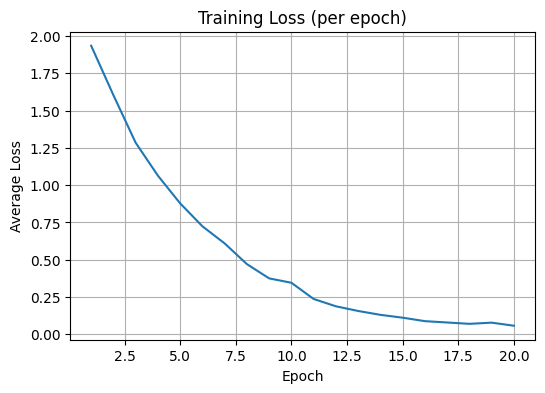

Loading best model and evaluating on test dataset...
Accuracy on the evaluation dataset = 83.33%, loss = 0.60
PyTorch ResNet18 (pretrained) - Final Test Accuracy: 0.8333 (83.33%)


In [24]:
# 4.2 Train the resnet18 with pretrained weights
model = pytorch_resnet18(pretrained=True)
save_path = os.path.join(weights_root, 'model_cnn_task1_4_2.pkl')

##############################################################################
# TODO: Train a ResNet18 from torchvision with pretrained weights.
# - Initialize ResNet18 with pretrained weights on ImageNet (pretrained=True)
# - Replace the final fully connected layer with output size 7
# - Use Adam optimizer with a suitable learning rate and number of epochs
# - Train the model, save the best checkpoint, then reload and evaluate on test set
##############################################################################


model.fc = torch.nn.Linear(model.fc.in_features, 7)

# Move model to device
model.to(device)


learning_rate = 1e-4  # Adjust to avoid underfitting
epochs = 20   # Adjust to avoid underfitting

# Set up optimizer with lower learning rate for fine-tuning
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model with pretrained weights
print("Training PyTorch ResNet18 with pretrained weights (transfer learning)...")
epoch_losses = train_net(model, dataloader_train, dataloader_val, optimizer, save_path, epochs)

# Reload the saved model and evaluate on test dataset
print("Loading best model and evaluating on test dataset...")
model.load_state_dict(torch.load(save_path, map_location=device))
model.eval()

# Run evaluation on test dataset
test_accuracy = eval_on_dataset(model, dataloader_test)
print(f"PyTorch ResNet18 (pretrained) - Final Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")



##############################################################################
#               END OF YOUR CODE
##############################################################################

### **[5%] Q1.4: Write your observations and analysis in the pdf file based on all the experiments on Q1:**

To write your observation and analysis with figures or tables. (Note: overfitting must be discussed)

---

## Task 2: Surgical Action Recognition [25%]

In this task, you will move from instrument classification to action recognition in surgical images. The goal is to recognize fine-grained surgical actions (e.g., “picking up the needle”, “knot tying”) from individual frames sampled from a long procedure. Unlike instrument classification, action recognition is more challenging because a single frame may be visually ambiguous, and distinguishing between actions requires robust spatial feature extraction. This setting introduces challenges such as visual occlusions, class imbalance, and the high similarity between different actions.

We will start from a simple, strong baseline and train it end-to-end: **ResNet → Classifier**. As illustrated in the figure, the pipeline (i) takes a single frame as input, (ii) extracts features with a ResNet18 backbone (with pretrained ImageNet weights), and (iii) outputs an action label for frame-level prediction.

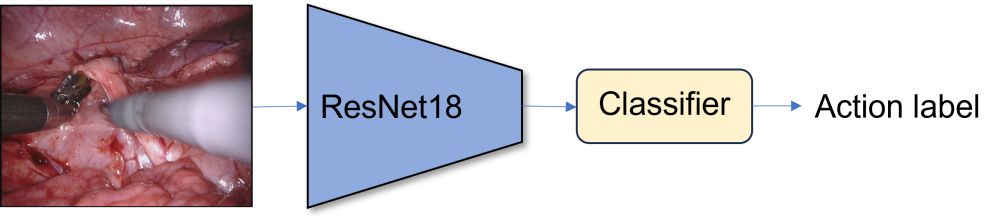

### **[7%] Q2.1** Design the action recognition dataset

In [29]:
# import all the package required for task2
from torchvision.transforms import v2 as transforms2
import torchvision.transforms as transforms
import torch.utils.data as data
from torch.utils.data import ConcatDataset
from torchvision.models import resnet18, ResNet18_Weights
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torch.utils.data.dataset as Dataset
import torch.nn as nn
from PIL import Image

if torch.cuda.is_available():
  device = 'cuda:0'  # choose your device here
else:
  device = 'cpu'
print('Using device:', device)

Using device: cuda:0


In [30]:
class RARPReader(data.Dataset):
  """
  RARPReader is designed to read from RARP dataset.
  With this dataset reader, we can get tensor: [batch_size, c, h, w]
  """
  def __init__(self, seq_image_dir, seq_action_path, resize_hw=(256, 512), is_train=True):
    self.seq_image_dir = seq_image_dir
    self.seq_action_path = seq_action_path
    self.img_list = []
    for root, dirs,files in os.walk(seq_image_dir):
        for file in files:
            self.img_list.append(os.path.join(root, file))
    self.img_list = sorted(self.img_list)
    self.is_train = is_train
    self.label_ranges = self.load_ranges(seq_action_path)
    ##############################################################################
    # TODO: Resize frames to resize_hw and define image transforms.
    # Requirements:
    # - Use PIL→Tensor (ToTensor) and normalize with ImageNet mean/std
    # - If is_train=True, you should at least add mild spatial augmentations
    #   (e.g., ColorJitter)
    ##############################################################################
    # Define image transforms
    if is_train:
      self.transform = transforms.Compose([
        transforms.Resize(resize_hw),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      ])
    else:
      self.transform = transforms.Compose([
        transforms.Resize(resize_hw),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      ])




    # ##############################################################################
    #              END OF YOUR CODE
    # ##############################################################################


  def load_ranges(self, txt_path):
    ##############################################################################
    # TODO: Load the ranges in the txt file, and get the list with format:
    ##############################################################################
    ranges = []
    with open(txt_path, 'r') as f:
      for line in f:
        line = line.strip()
        if line:  # Skip empty lines
          # Handle comma-separated values (format: "00000,01463,0")
          parts = line.split(',')
          start_frame = int(parts[0])
          end_frame = int(parts[1])
          action_id = int(parts[2])
          ranges.append((start_frame, end_frame, action_id))



    # ##############################################################################
    #              END OF YOUR CODE
    # ##############################################################################
    return ranges

  def get_label(self, frame_id, ranges):
    ##############################################################################
    # TODO: get the label based on frame_id
    ##############################################################################
    for start_frame, end_frame, action_id in ranges:
      if start_frame <= frame_id <= end_frame:
        return action_id

    # If no range found, return 0
    return 0




    # ##############################################################################
    #              END OF YOUR CODE
    # ##############################################################################

  def __len__(self):
    return len(self.img_list)

  def __getitem__(self, sample_idx):
    ##############################################################################
    # TODO: Read a single frame and apply transforms.
    # - Open the sampled image, convert to RGB, resize to (256, 512) and apply transforms
    # - If it is training, apply augmentation
    ##############################################################################

    #print(f"Sample index: {sample_idx}, Total images: {len(self.img_list)}")

    if sample_idx >= len(self.img_list):
        print(f"Innjknjkdex {sample_idx} out of range for {len(self.img_list)} images")
        return None, None

    # Get image path and load image
    img_path = self.img_list[sample_idx]
    #print(f"Loading image: {img_path}")

    image = Image.open(img_path).convert('RGB')

    # Apply transforms
    image = self.transform(image)

    # Get frame ID from filename
    frame_filename = os.path.basename(img_path)

    # Case 1: numeric filenames like "04020.jpg"
    if frame_filename.split('.')[0].isdigit():
        frame_id = int(os.path.splitext(frame_filename)[0])
    else:
        # Case 2: filenames with underscores like "v01_027575_Sc.jpg"
        parts = frame_filename.split('_')
        for p in parts:
            if p.isdigit():  # pick the numeric part
                frame_id = int(p)
                break
        else:
            raise ValueError(f"Cannot extract frame_id from filename: {frame_filename}")

    # Get label from ranges
    label = self.get_label(frame_id, self.label_ranges)





    # ##############################################################################
    #            END OF YOUR CODE
    # ##############################################################################

    return image, label

# define the data class
class RARPDataset(Dataset.Dataset):
  # Segmentation classes (mask labels)
  # NOTE:
  # 0 -> Other
  # 1 -> Picking-up the needle
  # 2 -> Positioning the needle tip
  # 3 -> Pushing the needle through the tissue
  # 4 -> Pulling the needle out of the tissue
  # 5 -> Tying a knot
  # 6 -> Cutting the suture
  # 7 -> Returning/dropping the needle
  def __init__(self, dataset_root, resize_hw=(256, 512), is_train=True):
    self.is_train = is_train
    self.dataset_root = dataset_root
    self.sub_reader = []
    self.seq_list = os.listdir(os.path.join(dataset_root, 'images'))
    for seq in self.seq_list:
      seq_image_dir = os.path.join(dataset_root, 'images', seq)
      seq_action_path = os.path.join(dataset_root, 'actions', seq + '.txt')
      # ##############################################################################
      # TODO: Use RARPReader to load each sequence
      # - Instantiate a RARPReader with the given image directory and action file
      # - Append the RARPReader object to self.sub_reader
      # ##############################################################################
      rarp_reader = RARPReader(seq_image_dir, seq_action_path, resize_hw, is_train)
      self.sub_reader.append(rarp_reader)

      # ##############################################################################
      #         END OF YOUR CODE
      # ##############################################################################

    # Concat all the sub-readers
    self.dataset = ConcatDataset(self.sub_reader)

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, index):
    return self.dataset[index]

### **[5%] Q2.2** Design your image-level action recognition model using ResNet18

In [31]:
# build the model with pretrained ResNet18
class RARPResnet(nn.Module):
  def __init__(self, num_classes=8):
    super(RARPResnet, self).__init__()
    self.num_classes = num_classes
    ##############################################################################
    # TODO: Model structure (backbone + temporal block + classifier)
    # Requirements:
    # - Backbone: build a ResNet18 feature extractor from torchvision with
    #   pretrained weights. Remove the final fully connected layer (keep avgpool).
    # - Classifier: a Linear head mapping d_model -> num_classes.
    ##############################################################################
    self.backbone = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
    self.backbone.fc = nn.Identity()
    self.classifier = nn.Linear(512, num_classes)

    # ##############################################################################
    #              END OF YOUR CODE
    # ##############################################################################

  def forward(self, x):
    ##############################################################################
    # TODO: Forward pass (shape flow)
    # - Input: x (B, 3, H, W)
    # - Backbone: extract features → (B, d_model)
    # - Average over time → sequence vector (B, d_model)
    # - Classifier → logits (B, num_classes)
    ##############################################################################
    features = self.backbone(x)
    # Classify features
    logits = self.classifier(features)

    # ##############################################################################
    #             END OF YOUR CODE
    # ##############################################################################
    return logits


### **[8%] Q2.3**: Training and evaluation.

In [32]:
import torch
from sklearn.metrics import f1_score

def rarp_evaluate(model, loader, device='cuda'):
  # ##############################################################################
  # TODO: RARP evaluation function
  # Requirements:
  # - Refer to Task 1's evaluation function.
  # - Forward pass to get logits and compute accuracy
  # - Added F1 score calculation
  # - Print the results
  # ##############################################################################

    model.eval()
    correct = 0
    total = 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
      for batch_idx, (data, target) in enumerate(loader):
        data, target = data.to(device), target.to(device)

        # Forward pass
        output = model(data)


        pred = output.argmax(dim=1, keepdim=True)


        correct += pred.eq(target.view_as(pred)).sum().item()
        total += target.size(0)


        all_predictions.extend(pred.cpu().numpy().flatten())
        all_labels.extend(target.cpu().numpy())

    # Calculate accuracy
    accuracy = correct / total


    f1 = f1_score(all_labels, all_predictions, average='macro')

    # Print results
    print(f'Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)')
    print(f'F1 Score (macro): {f1:.4f}')

    return accuracy, f1

  # ##############################################################################
  #              END OF YOUR CODE
  # ##############################################################################

In [40]:
# ##############################################################################
# TODO: RARP training
# Requirements:
# - Refer to Task 1
# - Run the training loop:
#   forward pass -> compute loss -> backward pass -> optimizer.step
# - Track average training loss per epoch and append to `train_losses`
# - Periodically evaluate to get validation accuracy
# - After training, plot the loss curve from `train_losses` as in Task 1
# - Save two models: (1) rarp_model_best.pth for the best validation accuracy; (2) rarp_model.pth for the last epoch.
# ##############################################################################
def rarp_training(model, train_loader, optimizer, scheduler, criterion):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    train_losses = []
    best_val_acc = 0.0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        # Training loop
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)

            # Zero gradients
            optimizer.zero_grad()

            # Forward pass
            output = model(data)
            loss = criterion(output, target)

            # Backward pass
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Calculate average training loss
        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Learning rate scheduling
        scheduler.step()

        # Validation evaluation
        if (epoch + 1) % 5 == 0:  # Evaluate every 5 epochs
            val_acc, val_f1 = rarp_evaluate(model, val_loader, device)

            # Save best model
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                torch.save(model.state_dict(), os.path.join(weights_root, 'rarp_model_best.pth'))
                print(f'Epoch {epoch+1}: New best validation accuracy: {val_acc:.4f}')

            print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Acc: {val_acc:.4f}')
        else:
            print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}')

    # Save final model
    torch.save(model.state_dict(), os.path.join(weights_root, 'rarp_model.pth'))
    print(f'Training completed. Best validation accuracy: {best_val_acc:.4f}')

    # Plot training loss curve
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses)
    plt.title('RARP Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()

    return train_losses



# ##############################################################################
#      END OF YOUR CODE
# ##############################################################################

In [41]:
# ##############################################################################
# TODO: Adjust the hyperparameters to make the model converge
# ##############################################################################
num_epochs = 40
learning_rate = 1e-4
batch_size = 16
step_size=8
# ##############################################################################
#             END OF YOUR CODE
# ##############################################################################
log_interval = 10
eval_interval = 5
num_classes = 8

In [42]:
# Prepare datasets and dataloaders
from google.colab import drive
drive.mount('/content/drive')
drive_root = '/content/drive/MyDrive/NUS/BN5211'
# drive_root = '../'  # For local usage

weights_root = os.path.join(drive_root, 'weights')
dataset_root = os.path.join(drive_root, 'RARP_1FPS')

path_train = os.path.join(dataset_root, 'train')
path_val = os.path.join(dataset_root, 'val')
path_test = os.path.join(dataset_root, 'test')

dataset_train = RARPDataset(path_train, resize_hw=(256,512))
dataset_val = RARPDataset(path_val, resize_hw=(256,512), is_train=False)
dataset_test = RARPDataset(path_test, resize_hw=(256,512), is_train=False)

train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(dataset_val, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=False, num_workers=4)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [43]:
!pip install -q torchinfo
from torchinfo import summary

# Instantiate the model and move it to the appropriate device
model = RARPResnet(num_classes=num_classes).to(device)
# Print the model architecture
# pip install torchinfo
summary(
  model, input_size=(1, 3, 256, 512),
  col_names=("input_size","output_size","num_params"),
  depth=3
)
# Use Adam optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=0.5)
# Prepare data loaders
criterion = nn.CrossEntropyLoss().to(device)
# For recording training loss
train_losses = []

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 237MB/s]


Starting RARP training...
Epoch 1/40, Train Loss: 1.1838
Epoch 2/40, Train Loss: 0.5343
Epoch 3/40, Train Loss: 0.2246
Epoch 4/40, Train Loss: 0.1090
Accuracy: 0.4378 (43.78%)
F1 Score (macro): 0.2747
Epoch 5: New best validation accuracy: 0.4378
Epoch 5/40, Train Loss: 0.0580, Val Acc: 0.4378
Epoch 6/40, Train Loss: 0.0434
Epoch 7/40, Train Loss: 0.0478
Epoch 8/40, Train Loss: 0.0318
Epoch 9/40, Train Loss: 0.0203
Accuracy: 0.4678 (46.78%)
F1 Score (macro): 0.3247
Epoch 10: New best validation accuracy: 0.4678
Epoch 10/40, Train Loss: 0.0127, Val Acc: 0.4678
Epoch 11/40, Train Loss: 0.0108
Epoch 12/40, Train Loss: 0.0112
Epoch 13/40, Train Loss: 0.0082
Epoch 14/40, Train Loss: 0.0061
Accuracy: 0.4807 (48.07%)
F1 Score (macro): 0.3238
Epoch 15: New best validation accuracy: 0.4807
Epoch 15/40, Train Loss: 0.0065, Val Acc: 0.4807
Epoch 16/40, Train Loss: 0.0041
Epoch 17/40, Train Loss: 0.0059
Epoch 18/40, Train Loss: 0.0047
Epoch 19/40, Train Loss: 0.0037
Accuracy: 0.4764 (47.64%)
F1 Sc

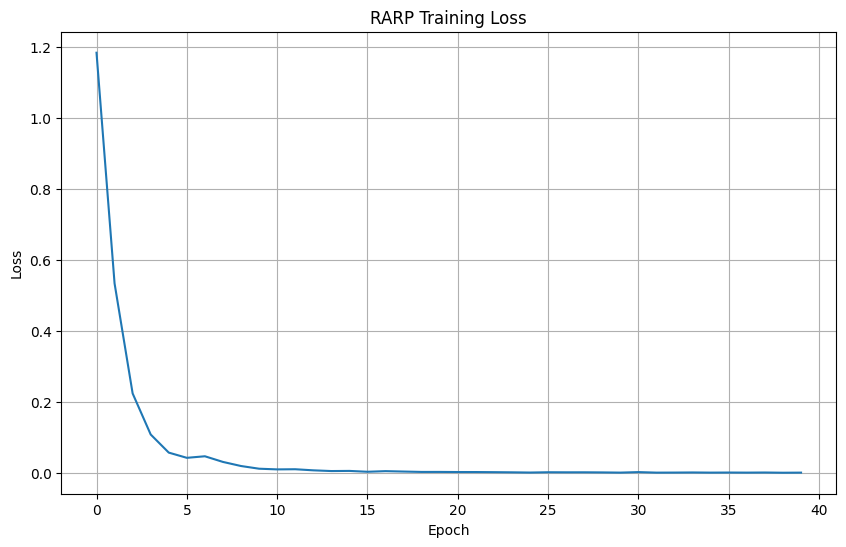

In [31]:
# ##############################################################################
# TODO: Training on RARP
# ##############################################################################


# DataLoaders
train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = torch.utils.data.DataLoader(dataset_val, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=False, num_workers=0)

# Train
print("Starting RARP training...")
train_losses = rarp_training(
    model=model,
    train_loader=train_loader,
    optimizer=optimizer,
    scheduler=scheduler,
    criterion=criterion
)

# ##############################################################################
#          END OF YOUR CODE
# ##############################################################################

In [44]:
# ##############################################################################
# TODO: Evaluate on RARP test set, and print the accuracy
# ##############################################################################
model_path = os.path.join(weights_root, 'rarp_model.pth')
if os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path, map_location=device))
    print(f"Model loaded successfully from {model_path}")
else:
    print(f"Model file {model_path} not found. Using current model state.")

# Ensure model is on the same device as the data
model = model.to(device)
model.eval()

# Evaluate on test set
print("Evaluating RARP model on test dataset...")
test_acc, test_f1 = rarp_evaluate(model, test_loader, device)

print(f"\n=== RARP TEST RESULTS ===")
print(f"Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"Test F1 Score (macro): {test_f1:.4f}")


# ##############################################################################
#          END OF YOUR CODE
# ##############################################################################

Model loaded successfully from /content/drive/MyDrive/NUS/BN5211/weights/rarp_model.pth
Evaluating RARP model on test dataset...
Accuracy: 0.6366 (63.66%)
F1 Score (macro): 0.4196

=== RARP TEST RESULTS ===
Test Accuracy: 0.6366 (63.66%)
Test F1 Score (macro): 0.4196


Test Accuracy: 0.6366 (63.66%)
Test F1 Score (macro): 0.4196


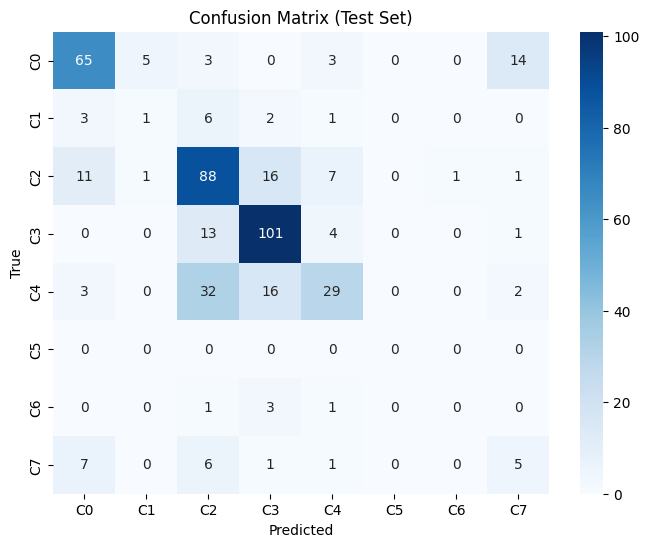

In [45]:
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Switch to evaluation mode
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        preds = output.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(target.cpu().numpy())

# Compute accuracy & F1
acc = np.mean(np.array(all_preds) == np.array(all_labels))
f1 = f1_score(all_labels, all_preds, average='macro')
print(f"Test Accuracy: {acc:.4f} ({acc*100:.2f}%)")
print(f"Test F1 Score (macro): {f1:.4f}")

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds, labels=np.arange(model.num_classes))

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=[f"C{i}" for i in range(model.num_classes)],
            yticklabels=[f"C{i}" for i in range(model.num_classes)])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Test Set)")
plt.show()


/tmp/ipython-input-59114194.py:2: RuntimeWarning: invalid value encountered in divide
  cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


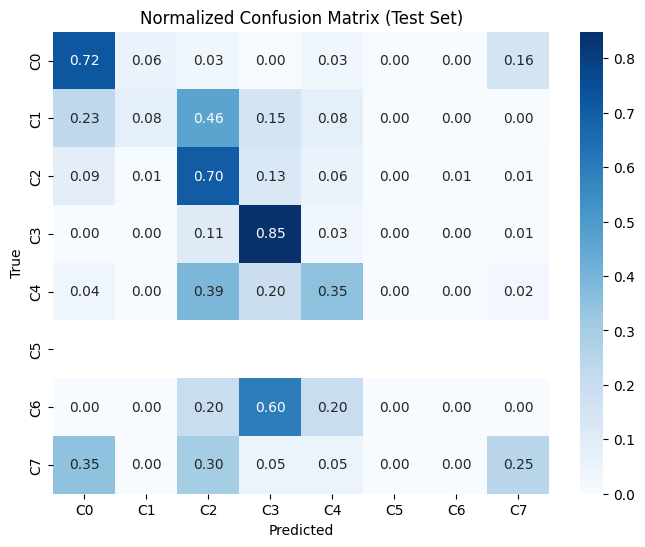

In [46]:
# Normalized confusion matrix
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8,6))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=[f"C{i}" for i in range(model.num_classes)],
            yticklabels=[f"C{i}" for i in range(model.num_classes)])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Normalized Confusion Matrix (Test Set)")
plt.show()


---

### **[5%] Q2.4: Write your observations and analysis in the pdf based on Task 2:**

To write your observation and analysis with tables or figures.

---

## Task 3: Constrastive learning **[35%]**

In Task 1, we have trained the deep learning model by optimizing the nework with the guidance of label. However, the labeling work is timeconsuming and difficult to achieve accurate label in various tasks. The reliance on large scale data of deep learning models makes us need to think: How to use the unlabeled data to benefit optimization?

### The target of constrastive learning

To use unlabeled data to benefit model optimization, contrastive learning was born. It can realize the model optimization by large unlabeled data and few labeled data. The principle of contrastive learning is: Learn the same features among instances of the same class and distinguish differences between instances of the same class. The learning process does not require the label of each instance. It can provide a pre-trained model without labels for fine-tunning.


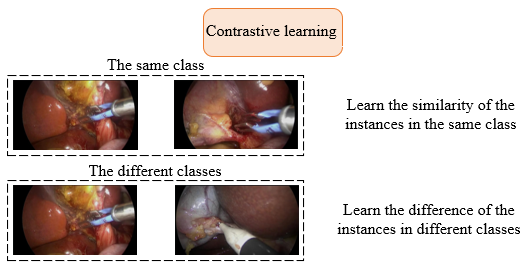

As shown in the following figure, the instances of different classes.

1. **For the positive pairs**: Because of the smilar regions (red box), the different instances of Bipolar are grouped into the same class. The backgroud regions are not important for the classification task. Hence, the distance between the two instances can be measured by the similarity calculation on the red box.
2. **For the negative pairs**: Because of the difference between Hook instance and Bipolar instance (red box), the two instances should be classified into different classes.

Hence, if a network could narrow the distance of instances in the same class and enlarge the distance of instance in the different class, this network can realize the classification without labels.

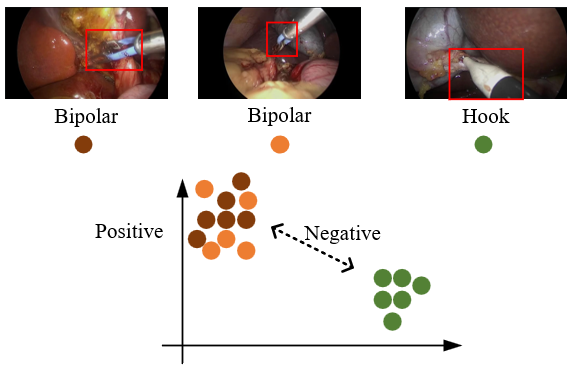

To make this ability available, contrastive learning constructs the positive and negative pairs to guide the network distingush each instance. Though comparing the similarity and difference, the network could understand the class of each instance.

There are lots of strategies in contrastive learning to realize this. Here, we conduct the strategy: guiding the network capture the similarity of instances in the same class by contrastive learning.

### Set a contrastive learning strategy

Here, we set a contrastive learning following the strategy in the figure. It consists of 3 steps:


1.   **Set contrastive pairs.** Different from the above Task 1-2, we need to construct the positive and negative pairs for comparison of similarity. Due to the lack of labels, the positive pairs cannot be find directly. Hence, we takes different data augmentation ways on the same image to generate two images as a pair (like Bipolar and Bipolar'). Because the generated images are from the same image, they must be the same class. The negative pair can be the randomly generated features.
2.   **Define the convolutional layers.** Since the target of optimization is the network for q (left network), the network for k could not have the gradient in training process. With the generated positive and negative pairs, the similarity can be calculated. For the positive pair, the similarity is enlarged. For the negative pair, the similarity is narrowed.
3.   **Training contrastive learning network.** With the defined network and dataset in step 1-2, we can conduct the model optimization without the labels. Through the training, the network could distinguish the similar instances in the same class.   
4.   **Fine-tunning on the trained network.** With the pre-trained network by contrastive learning, we can fine-tune it to realize classification by few labels.

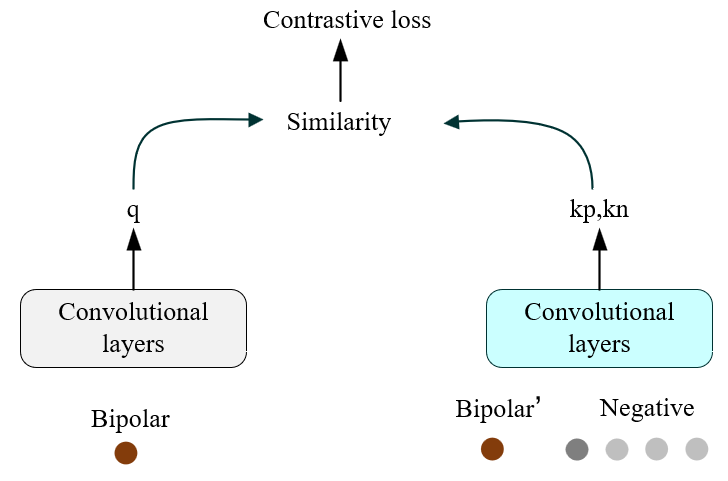

###  **[5%] Q3.1**: Set contrastive pairs.

Different from the dataloader in Task 1, the contrastive learning requires establishing the positive image pairs (by applying different augmentations to an image). For augmentation operations, please refer to Task 1. Here, the label of the image is ignored.

In [12]:
class PairDataset(Dataset.Dataset):
  def __init__(self, img_list, is_train=True):
    self.img_list = img_list
    self.is_train = is_train
    self.resize = torchvision.transforms.Resize((175, 300))
    ##############################################################################
    # TODO: Define random image augmentation transforms.
    # - Use simple augmentations such as random flip and random rotation
    # - Ensure consistency with Task 1 (augmentation style)
    ##############################################################################
    # Define augmentation transforms for contrastive learning
    self.augmentation_transforms = torchvision.transforms.Compose([
        torchvision.transforms.RandomHorizontalFlip(p=0.5),
        torchvision.transforms.RandomRotation(degrees=15),
        torchvision.transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        torchvision.transforms.RandomResizedCrop(size=(175, 300), scale=(0.8, 1.0), ratio=(0.9, 1.1))
    ])

    ##############################################################################
    #            END OF YOUR CODE
    ##############################################################################
    self.image_transforms = torchvision.transforms.Compose([
      torchvision.transforms.ToTensor(),
      torchvision.transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

  def __len__(self):
    return len(self.img_list)

  def __getitem__(self, index):
    img_name = self.img_list[index]
    image = Image.open(img_name)
    # Data augmentation
    image = self.resize(image)

    ##############################################################################
    # TODO: Generate two different augmented views of the same image.
    # - Apply the augmentation transforms independently on the resized image
    # - Each call should produce a different random view (positive pair)
    ##############################################################################

    # Perform augmentation to get image1
    image1 = self.augmentation_transforms(image)

    # Perform augmentation to get image2
    image2 = self.augmentation_transforms(image)

    ##############################################################################
    #             END OF YOUR CODE
    ##############################################################################

    image1 = self.image_transforms(image1)
    image2 = self.image_transforms(image2)

    return image1, image2

Define the dataloader for training and testing.

In [13]:
# Read all images' path
img_list_train_full = []
for root, dirs, files in os.walk(full_dataset_dir):
  for file in files:
    img_list_train_full.append(os.path.join(full_dataset_dir, file))
size_train_full = len(img_list_train_full)

# Training data
train_full_data = PairDataset(img_list_train_full, True)
# Testing data, same as task1
test_data = PairDataset(img_list_test, False)

# Set the batch_size
batch_size = 8

# Train_dataloader should drop_last to prevent error in the queue of contrastive learning
train_full_loader = torch.utils.data.DataLoader(dataset=train_full_data, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)

Visualize the image pair. These images are normalized and therefore with different colors.

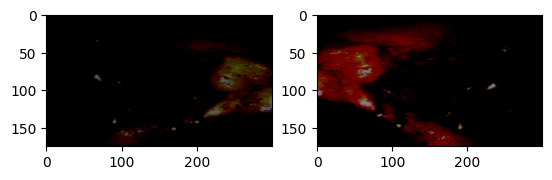

In [14]:
# Choose a picture at random
image1_norm, image2_norm = train_full_data.__getitem__(2)

image1_norm = np.transpose(image1_norm, [1, 2, 0])
image2_norm = np.transpose(image2_norm, [1, 2, 0])

plt.subplot(1, 2, 1)
plt.imshow(image1_norm)
plt.subplot(1, 2, 2)
plt.imshow(image2_norm)
plt.show()

### **[12%] Q3.2**: Define the convolutional layers.

Based on the defined ConvNet in Task 1, we construct the contrastive learning model. Compared with the ConvNet in Task 1, we just reduce two linear layers in the end.

In [15]:
class ConvNetNew(torch.nn.Module):
  def __init__(self):
    super(ConvNetNew, self).__init__()
    ##############################################################################
    # TODO: Build a CNN encoder (representation learning).
    # Requirements:
    # - Stack multiple Conv-BN-ReLU-MaxPool blocks
    # - Apply AdaptiveAvgPool2d to reduce features to 1×1
    # - Replace the final linear layers with a 256→128 projection head
    # - Output a 128-D feature embedding (no classifier here)
    # - Input: (B,3,H,W), H,W≥64; Output: (B,128); Do NOT hard-code H,W
    ##############################################################################

    # Block 1: 3 x 175 x 300 --> 32 x 87 x 150
    self.block1 = torch.nn.Sequential(
        torch.nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
        torch.nn.BatchNorm2d(32),
        torch.nn.ReLU(inplace=True),
        torch.nn.MaxPool2d(kernel_size=2, stride=2)
    )

    # Block 2: 32 x 87 x 150 --> 64 x 43 x 75
    self.block2 = torch.nn.Sequential(
        torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
        torch.nn.BatchNorm2d(64),
        torch.nn.ReLU(inplace=True),
        torch.nn.MaxPool2d(kernel_size=2, stride=2)
    )

    # Block 3: 64 x 43 x 75 --> 128 x 21 x 37
    self.block3 = torch.nn.Sequential(
        torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
        torch.nn.BatchNorm2d(128),
        torch.nn.ReLU(inplace=True),
        torch.nn.MaxPool2d(kernel_size=2, stride=2)
    )

    # Block 4: 128 x 21 x 37 --> 256 x 10 x 18
    self.block4 = torch.nn.Sequential(
        torch.nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
        torch.nn.BatchNorm2d(256),
        torch.nn.ReLU(inplace=True),
        torch.nn.MaxPool2d(kernel_size=2, stride=2)
    )

    # Block 5: 256 x 10 x 18 -> 256 x 5 x 9
    self.block5 = torch.nn.Sequential(
        torch.nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
        torch.nn.BatchNorm2d(256),
        torch.nn.ReLU(inplace=True),
        torch.nn.MaxPool2d(kernel_size=2, stride=2)
    )

    # AdaptiveAvgPool: 1 x 1
    self.adaptive_pool = torch.nn.AdaptiveAvgPool2d((1, 1))

    # Linear layers: 256 x 1 x 1 --> 128
    self.projection_head = torch.nn.Sequential(
        torch.nn.Linear(256, 128),
        torch.nn.ReLU(inplace=True),
        torch.nn.Linear(128, 128)
    )


    ##############################################################################
    #            END OF YOUR CODE
    ##############################################################################

  def forward(self, x):
    ##############################################################################
    # TODO: implement the forward
    # Note: same as Task 1
    ##############################################################################

    # Block 1: 3 x 175 x 300 --> 32 x 87 x 150
    x = self.block1(x)

    # Block 2: 32 x 87 x 150 --> 64 x 43 x 75
    x = self.block2(x)

    # Block 3: 64 x 43 x 75 --> 128 x 21 x 37
    x = self.block3(x)

    # Block 4: 128 x 21 x 37 --> 256 x 10 x 18
    x = self.block4(x)

    # Block 5: 256 x 10 x 18 --> 256 x 5 x 9
    x = self.block5(x)

    # AdaptiveAvgPool: 256 x 1 x 1
    x = self.adaptive_pool(x)

    # Flatten and Linear layers: 256 x 1 x 1 --> 128
    x = x.view(x.size(0), -1)  # Flatten
    x = self.projection_head(x)

    # L2 normalize embeddings
    x = F.normalize(x, dim=1)

    ##############################################################################
    #            END OF YOUR CODE
    ##############################################################################
    return x


With the defined convolution layers (ConvNetNew()), the whole contrastive learning framework could be constructed. The encoder_q and encoder_k have the same convolutional layers. However, the encoder_k will not be optimized by the training (the gradient of encoder_k should be set False). To update the parameters of encoder_k, the parameters will copy encoder_q's.

In [19]:
class ConLNet(torch.nn.Module):
  def __init__(self):
    super(ConLNet, self).__init__()
    ##############################################################################
    # TODO: Define the convolutional encoders q & k (no linear layers)
    # Tips: refer to: https://arxiv.org/abs/1911.05722 and https://github.com/facebookresearch/moco
    # Requirements:
    # - Build encoder_q and encoder_k based on ConvNetNew
    # - Initialize encoder_k with encoder_q’s parameters
    # - Set encoder_k parameters to not require gradients
    # - Follow MoCo design (refer to paper and codebase)
    # - Use a momentum update for encoder_k in forward: k = m*k + (1-m)*q (under torch.no_grad())
    # - Maintain a feature queue (dim=128, size=K) as buffers (register_buffer) and L2-normalize q/k
    # - Set encoder_k.eval() during forward to freeze BN running stats
    ##############################################################################

    # Create encoder_q and encoder_k  Hint: define the encoder_q and encoder_k based on ConvNetNew()
    self.encoder_q = ConvNetNew()
    self.encoder_k = ConvNetNew()

    # Copy encoder_q's paremeter to encoder_k, and set requires_grad of parameter to False
    for param_q, param_k in zip(self.encoder_q.parameters(), self.encoder_k.parameters()):
        param_k.data.copy_(param_q.data)
        param_k.requires_grad = False

    # Set temperature for infoNCE (T=0.07), momentum updating (m=0.99), feature dimension (dim=128), queue size (K=160)
    # Temperature for infoNCE
    self.T = 0.07

    # Momentum updating
    self.m = 0.99

    # Feature dimension
    self.dim = 128

    # Queue size
    self.K = 160

    # Set a queue pointer (queue_ptr) to manage the queue, which helps locate the position of queue
    self.register_buffer('queue_ptr', torch.zeros(1, dtype=torch.long))

    # Create the 128 negative instance features by torch.randn, feature size is dim, queue size is K
    self.register_buffer('queue', torch.randn(self.dim, self.K))
    self.queue = torch.nn.functional.normalize(self.queue, dim=0)

  def infoNCE(self, q, k):
    # Positive logits: Nx1 （Multiply the corresponding elements of the matrix and sum them row by row) on q and k
    l_pos = torch.einsum('nc,nc->n', [q, k]).unsqueeze(-1)  # Nx1

    # Negative logits: NxK  (matrix product) on q and the negative sample
    l_neg = torch.einsum('nc,ck->nk', [q, self.queue.clone().detach()])  # NxK

    # Concat logits: Nx(1+K)
    logits = torch.cat([l_pos, l_neg], dim=1)  # Nx(1+K)

    # Apply temperature to logits
    logits /= self.T

    # Set labels - FIXED: Use device-agnostic approach
    labels = torch.zeros(logits.shape[0], dtype=torch.long, device=logits.device)  # N

    # Calculate infoNCE by CrossEntropy using nn.functional.cross_entropy
    loss = torch.nn.functional.cross_entropy(logits, labels)

    return loss

  # Organize the queue when new keys are coming
  def _dequeue_and_enqueue(self, keys):
    # Get batch_size
    batch_size = keys.shape[0]

    # For simplicity, assert self.K % batch_size == 0
    assert self.K % batch_size == 0

    # Replace the keys at ptr (dequeue and enqueue) in the queue
    ptr = int(self.queue_ptr)
    self.queue[:, ptr:ptr + batch_size] = keys.T

    # Move pointer, and save it to self.queue_ptr for the next usage
    ptr = (ptr + batch_size) % self.K
    self.queue_ptr[0] = ptr

  def forward(self, im1, im2):
    with torch.no_grad():
        for param_q, param_k in zip(self.encoder_q.parameters(), self.encoder_k.parameters()):
            param_k.data = param_k.data * self.m + param_q.data * (1. - self.m)

    # Compute query features
    q = self.encoder_q(im1)
    q = torch.nn.functional.normalize(q, dim=1)

    # Compute key features
    with torch.no_grad():
        self.encoder_k.eval()  # freeze BN stats
        k = self.encoder_k(im2)
        k = torch.nn.functional.normalize(k, dim=1)

    # Contrastive loss
    loss = self.infoNCE(q, k)

    # Update queue
    self._dequeue_and_enqueue(k)

    return loss

    ##############################################################################
    #             END OF YOUR CODE
    ##############################################################################

### **[8%] Q3.3**: Training contrastive learning network.

From Q3.1 to Q3.2, the contrastive learning model and dataloader are defined. In this section, we will build up the forward process of contrastive learning. Without the label of each data, the loss is calculated by comparing the similarity of the features extracted by two parallel encoders.
One way to evaluate whether your code is right is to check the loss. The loss should decrease smoothly and then converge.

In [23]:
def plot_loss(losses):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(8,5))
    plt.plot(losses, label="Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Contrastive Learning Training Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

In [24]:
def train_contrastive_net(model, train_loader, optimizer, save_path, total_epochs=200):
  # Train contrastive learning
  epoch_losses = []
  model.train()
  for epoch in range(total_epochs):
    running_loss = 0.0
    for step, (image1_norm, image2_norm) in enumerate(train_loader):
      ##############################################################################
      # TODO: Complete the forward process
      # Requirements:
      # - Move both augmented views to device
      # - Forward through the model to get contrastive loss (infoNCE)
      # - Zero gradients, backpropagate, and update parameters
      # - Accumulate running loss for logging
      ##############################################################################


      image1_norm = image1_norm.to(device)
      image2_norm = image2_norm.to(device)

      # Zero gradients
      optimizer.zero_grad()

      # Calculate the loss by the defined model above
      loss = model(image1_norm, image2_norm)

      loss.backward()
      optimizer.step()

      # Accumulate running loss for logging
      running_loss += loss.item()

      ##############################################################################
      #            END OF YOUR CODE
      ##############################################################################
    avg_loss = running_loss / len(train_loader.dataset)
    epoch_losses.append(avg_loss)
    print('epoch= {} \t loss= {:.3f}'.format(epoch, avg_loss))
  # We only save encoder_q
  assert model.encoder_q is not None
  torch.save(model.encoder_q.state_dict(), save_path)
  print('Model saved to %s' % save_path)
  plot_loss(epoch_losses)
  return epoch_losses



epoch= 0 	 loss= 0.482
epoch= 1 	 loss= 0.408
epoch= 2 	 loss= 0.386
epoch= 3 	 loss= 0.388
epoch= 4 	 loss= 0.391
epoch= 5 	 loss= 0.386
epoch= 6 	 loss= 0.374
epoch= 7 	 loss= 0.392
epoch= 8 	 loss= 0.402
epoch= 9 	 loss= 0.431
epoch= 10 	 loss= 0.454
epoch= 11 	 loss= 0.448
epoch= 12 	 loss= 0.433
epoch= 13 	 loss= 0.392
epoch= 14 	 loss= 0.376
epoch= 15 	 loss= 0.385
epoch= 16 	 loss= 0.397
epoch= 17 	 loss= 0.418
epoch= 18 	 loss= 0.415
epoch= 19 	 loss= 0.423
epoch= 20 	 loss= 0.452
epoch= 21 	 loss= 0.455
epoch= 22 	 loss= 0.442
epoch= 23 	 loss= 0.429
epoch= 24 	 loss= 0.426
epoch= 25 	 loss= 0.446
epoch= 26 	 loss= 0.461
epoch= 27 	 loss= 0.451
epoch= 28 	 loss= 0.437
epoch= 29 	 loss= 0.432
epoch= 30 	 loss= 0.451
epoch= 31 	 loss= 0.473
epoch= 32 	 loss= 0.476
epoch= 33 	 loss= 0.466
epoch= 34 	 loss= 0.457
epoch= 35 	 loss= 0.461
epoch= 36 	 loss= 0.462
epoch= 37 	 loss= 0.480
epoch= 38 	 loss= 0.510
epoch= 39 	 loss= 0.521
epoch= 40 	 loss= 0.520
epoch= 41 	 loss= 0.487
ep

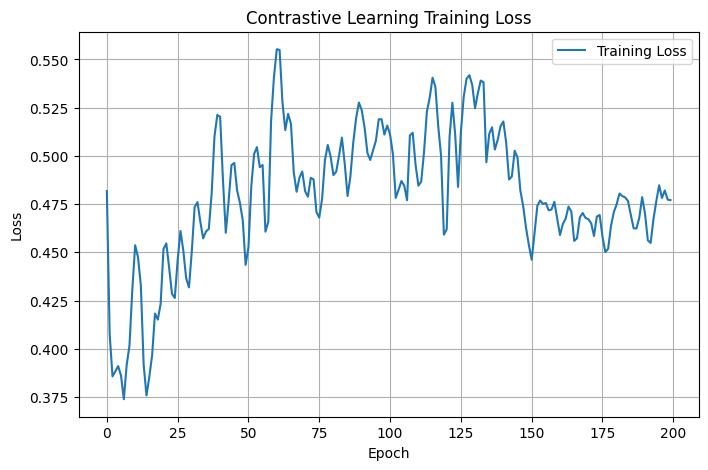

In [25]:
model = ConLNet()
model.to(device)
learning_rate = 0.001
epochs = 200
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
save_path = os.path.join(weights_root, 'task3_contrastive_model.pkl')
epoch_losses = train_contrastive_net(model, train_full_loader, optimizer, save_path, total_epochs=epochs)

### **[5%] Q3.4**: Fine-tunning on the trained network.

With the pre-trained network by contrastive learning, we can fine-tune it to realize classification by few labels. We need to load the pre-trained model for fine-tunning.

In [18]:
# Load pre-trained model
model_ft = ConvNet()
model_ft.to(device)

contrastive_model_path = os.path.join(weights_root, 'task3_contrastive_model.pkl')
pretrained_dict = torch.load(contrastive_model_path)
for key in list(pretrained_dict.keys()):
  # Only leave the backbone module, popping the linear layers
  if 'fc' in key:
    pretrained_dict.pop(key)
    print('Pretrained key {} removed'.format(key))

missing_keys, unexpected_keys = model_ft.load_state_dict(pretrained_dict, strict=False)
print('Model loaded from %s' % contrastive_model_path)
print('missing key: ', missing_keys)
ft_model_is_trained = False
# Since the contrastive model has different linear layers, the missing keys are fc1, fc2, fc3

Model loaded from /content/drive/MyDrive/NUS/BN5211/weights/task3_contrastive_model.pkl
missing key:  ['fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias']


Based on the pre-trained model, we can conduct few round fine-tunning.

In [19]:
# Define loss function
criterion = torch.nn.CrossEntropyLoss()
# Build data loaders
dataset_train = ImageDataset(img_list_train, True)
dataset_val = ImageDataset(img_list_val, False)
dataset_test = ImageDataset(img_list_test, False)

dataloader_train = torch.utils.data.DataLoader(dataset=dataset_train, batch_size=batch_size, shuffle=True)
dataloader_val = torch.utils.data.DataLoader(dataset=dataset_val, batch_size=batch_size, shuffle=False)
dataloader_test = torch.utils.data.DataLoader(dataset=dataset_test, batch_size=batch_size, shuffle=False)

Starting fine-tuning with contrastive pre-trained features...
Training samples: 178
Validation samples: 33
Test samples: 90
Epochs: 200, Batch size: 8, Learning rate: 0.001
epoch= 0 	 time= 0.09 min 	 loss= 2.052 	 accuracy= 12.36%
Accuracy on the evaluation dataset = 15.15%, loss = 1.98
Model saved at epoch 0
epoch= 1 	 time= 0.62 min 	 loss= 3.077 	 accuracy= 15.73%
epoch= 2 	 time= 0.65 min 	 loss= 2.235 	 accuracy= 20.79%
epoch= 3 	 time= 0.67 min 	 loss= 2.116 	 accuracy= 23.60%
epoch= 4 	 time= 0.70 min 	 loss= 1.963 	 accuracy= 21.91%
epoch= 5 	 time= 0.73 min 	 loss= 1.851 	 accuracy= 26.97%
Accuracy on the evaluation dataset = 30.30%, loss = 1.77
Model saved at epoch 5
epoch= 6 	 time= 0.77 min 	 loss= 1.927 	 accuracy= 27.53%
epoch= 7 	 time= 0.79 min 	 loss= 1.852 	 accuracy= 25.84%
epoch= 8 	 time= 0.82 min 	 loss= 1.842 	 accuracy= 23.60%
epoch= 9 	 time= 0.85 min 	 loss= 1.808 	 accuracy= 24.16%
epoch= 10 	 time= 0.91 min 	 loss= 1.731 	 accuracy= 30.90%
Accuracy on the e

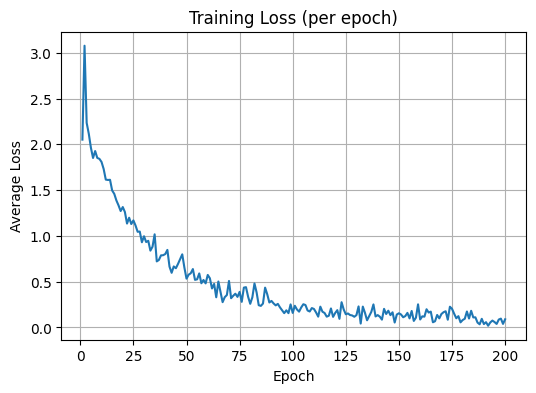

Loading best model and evaluating on test dataset...
Accuracy on the evaluation dataset = 68.89%, loss = 1.60

=== FINE-TUNING RESULTS ===
Fine-tuned Model (with contrastive pre-training) - Final Test Accuracy: 0.6889 (68.89%)


In [20]:
if ft_model_is_trained:
    print('Warning: the ft_model is already trained!')
else:
    ft_model_is_trained = True
finetune_model_path = os.path.join(weights_root, 'model_ft_task3.pkl')
##############################################################################
# TODO: Fine-tune `model_ft`.
# - Set hyperparameters (epochs, batch_size, learning_rate)
# - Define an optimizer for trainable params of `model_ft` (e.g., Adam)
# - Train with `train_net` and save the best checkpoint
# - Reload the saved weights and evaluate on the test set
##############################################################################


total_epochs = 200
batch_size = 8
learning_rate = 0.001

# Set up optimizer
optimizer = torch.optim.Adam(model_ft.parameters(), lr=learning_rate, weight_decay=1e-4)

# Start training
print("Starting fine-tuning with contrastive pre-trained features...")
print(f"Training samples: {len(dataset_train)}")
print(f"Validation samples: {len(dataset_val)}")
print(f"Test samples: {len(dataset_test)}")
print(f"Epochs: {total_epochs}, Batch size: {batch_size}, Learning rate: {learning_rate}")

epoch_losses = train_net(model_ft, dataloader_train, dataloader_val, optimizer, finetune_model_path, total_epochs)

# Start testing
print("Loading best model and evaluating on test dataset...")
model_ft.load_state_dict(torch.load(finetune_model_path, map_location=device))
model_ft.eval()

# Run evaluation on test dataset
test_accuracy = eval_on_dataset(model_ft, dataloader_test)
print(f"\n=== FINE-TUNING RESULTS ===")
print(f"Fine-tuned Model (with contrastive pre-training) - Final Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

# ##############################################################################
#             END OF YOUR CODE
# ##############################################################################

### **[5%] Q3.5**: Write your observations and analysis in the pdf based on Task 3:
To write your observation and analysis with tables or figures.

---